# Exercise 2: Variable flux reluctance machine

Having discussed the implementation details of a model of a simplified reluctance machine in exercise 1, we continue with a more realistic variable flux reluctance machine. The realistic machine consists of a stator with twelve teeth and coils, grouped in three phases, and a rotor with ten teeth.

![domain](exercise2.svg)

Contrary to the model of exercise 1, the model used here has a rotating rotor and the magnetic field will be solved in space and mechanical angle (or equivalently time assuming the angular velocity is constant) simultaneously. Because of the complexity of the geometry, the rotation of the rotor and solving for a range of mechanical angles simultaneously, the model is not included in this notebook, but in file [vfrm.py](vfrm.py). From this file we import class `Machine`, which will be used in this exercice.

In [1]:
from vfrm import Driver, Geometry, Machine, Angle, AngularFrequency, ElectricCurrent, Torque, Power
import nutils.function
import treelog_notebook

Class `Driver` describes the AC and DC currents that drive the motor and the mechanical angular frequency. Class `Machine` contains the entire mathematical description of the motor, including the namespace from the example 1 and plotting functions. We create an instance of `Driver` with `nutils.function.Argument`s such that we can later change these values without rerunning this entire notebook and peform an optimization. Then we create an instance of `Machine` given the `driver` instance. During instantiation of the `Machine` a mesh will be generated using gmsh, which will take a bit of time.

In [2]:
driver = Driver(
    peak_ac_current=nutils.function.Argument('Iacpeak', ()) * ElectricCurrent('A'),
    dc_current=nutils.function.Argument('Idc', ()) * ElectricCurrent('A'),
    mechanical_angular_frequency=nutils.function.Argument('speed', ()) * AngularFrequency('rpm'),
)
machine = Machine(driver=driver)

mesh > gmsh > Running 'C:\Users\mcurti\.virtualenvs\iemdc-OIQ8cT5z\Scripts\gmsh.bat\..\gmsh C:\Users\mcurti\Documents\projects\iemdc\vfrm.geo -o C:\Users\mcurti\AppData\Local\Temp\tmpmict9zfc.msh -order 2 -2 -bin -setnumber r_ri 0.0105 -setnumber h_ry 0.0205 -setnumber h_rt 0.014400000000000001 -setnumber h_a 0.000535 -setnumber h_sea 0.00775 -setnumber h_sed 0.00775 -setnumber h_sca 0.009000000000000001 -setnumber h_scd 0.00775 -setnumber h_s 0.024100000000000003 -setnumber a_rti 0.005 -setnumber a_rto 0.01 -setnumber n_rt 5 -setnumber a_sti 0.013000000000000001 -setnumber n_st 6 -setnumber h_e 0.01 -setnumber n_ea 1 -setnumber m 2 -setnumber f_i 0.5' [Gmsh 4.13.1, 1 node, max. 1 thread]
mesh > gmsh > Started on Sun May 18 18:37:23 2025
mesh > gmsh > Reading 'C:\Users\mcurti\Documents\projects\iemdc\vfrm.geo'...
mesh > gmsh > Done reading 'C:\Users\mcurti\Documents\projects\iemdc\vfrm.geo'
mesh > gmsh > Reconstructing periodicity for curve connection 11 - 1
mesh > gmsh > Reconstructin

Plot the generated mesh.

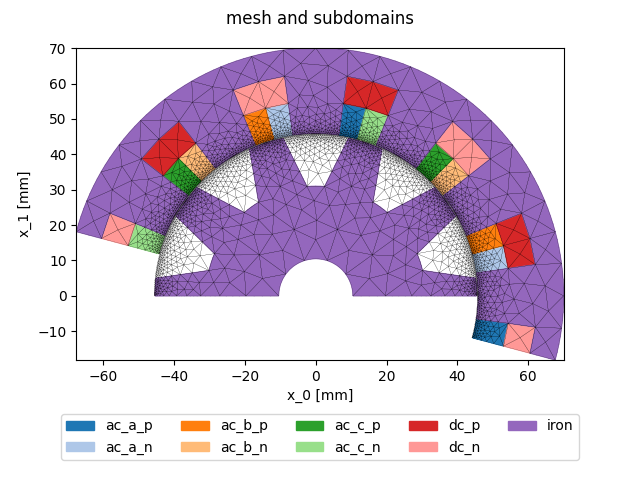

In [3]:
machine.plot_mesh()

The model is solved given the input currents, which are identified as peak value for AC currents and the constant current. The results are stored in `args`. This takes a long time.

In [4]:
args = dict(
    Iacpeak=30, # unit: A
    Idc=25, # unit: A
    speed=1000, # unit: rpm
)
args = machine.solve(arguments=args)

solve > solve > solving for argument A2 (8,13295) and λ (8,540) using direct method
solve > solve > residual norm: 4.1e-16


Once the magnetic model is solved, we have access to the solution for the entire timeslab. We could plot various field quantities at different mechanical angles `thetam` (between 0 and 6 degrees only).

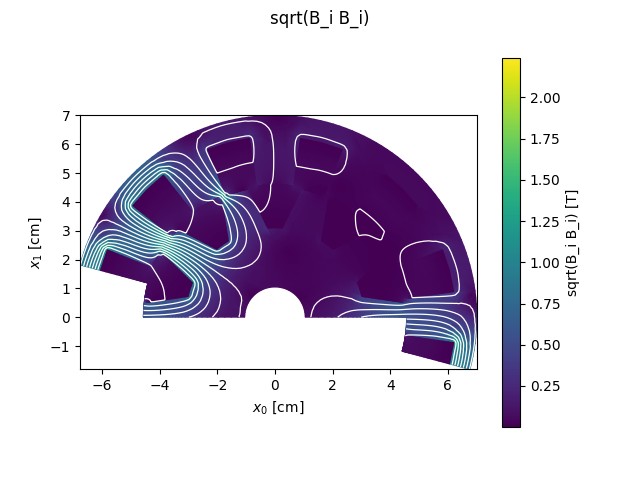

In [5]:
machine.plot_field(
    'sqrt(B_i B_i)', 'T',
    thetam=Angle('0deg'),
    arguments=args,
    contours='A2',
)

We can also plot time series of quantities that are invariant to space, such as flux, emf, phase currents and voltages and the torque.

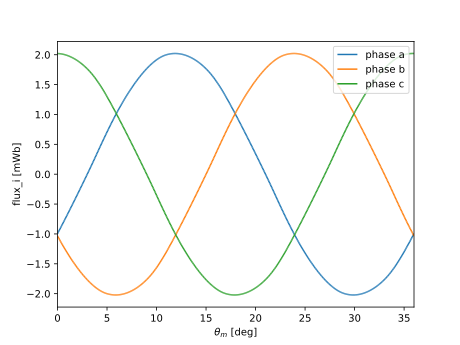

In [6]:
machine.plot_thetam('flux_i', 'mWb', phase=True, arguments=args)

# Other time series plots to try:
#
# AC emf per turn:    machine.plot_thetam('dt(flux_i)', 'V', phase=True, arguments=args)
# AC emf:             machine.plot_thetam('emf_i', 'V', phase=True, arguments=args)
# AC current:         machine.plot_thetam('Iac_i', 'A', phase=True, arguments=args)
# AC voltage:         machine.plot_thetam('Uac_i', 'V', phase=True, arguments=args)
# torque:             machine.plot_thetam('torque', 'N*m', arguments=args)

And we can print time-average quantities like the average rotor torque and power, and ac and dc power.

In [7]:
machine.print_scalar('Tavg(torque)', 'N*m', arguments=args)

# Other scalars to print:
#
# average AC power:          machine.print_scalar('Tavg(Uac_i Iac_i)', 'W', arguments=args)
# average AC copper losses:  machine.print_scalar('Tavg(Rac Iac_i Iac_i)', 'W', arguments=args)
# average AC power:          machine.print_scalar('Tavg(Pac)', 'W', arguments=args)
# average DC power:          machine.print_scalar('Tavg(Udc Idc)', 'W', arguments=args)
# average DC power:          machine.print_scalar('Tavg(Pdc)', 'W', arguments=args)
# average DC copper losses:  machine.print_scalar('Tavg(Rdc Idc Idc)', 'W', arguments=args)
# average rotor power:       machine.print_scalar('Tavg(torque) omegam', 'W', arguments=args)
# average rotor power:       machine.print_scalar('Tavg(Protor)', 'W', arguments=args)

Tavg(torque): 4.519N*m


We finish this exercise with a minimization problem: find the AC peak current and the DC current that minimizes the average input power for a torque of `10 N*m`.

The average input power is given by

$$ \frac{1}{T} \int_0^T (P_\text{ac} + P_\text{dc}) \ \mathrm dT. $$

We impose the torque using a lagrange multiplier $\lambda_\tau$. This gives the minimization problem: minimize $f$ for $I_\text{acpeak}$, $I_\text{dc}$ and $\lambda_\tau$ where

$$ f := \frac{1}{T} \int_0^T \left( \frac{1}{P_\text{ref}} (P_\text{ac} + P_\text{dc}) + \frac{1}{\tau_\text{ref}} \lambda_\tau (\tau - \tau_\text{target}) \right)\ \mathrm dT, $$

and $P_\text{ref} = W$ and $\tau_\text{ref} = N\ m$ are reference values to make the function $f$ dimensionless.

In [8]:
from nutils_solver_extra import minimize

ns = machine.ns.copy_()
ns.Pref = Power('W')
ns.torqueref = Torque('N*m')
ns.torquetarget = Torque('10N*m')
ns.lambdatorque = nutils.function.Argument('lambdatorque', ())
ns.f = 'Tavg((Pac + Pdc) / Pref + lambdatorque (torque - torquetarget) / torqueref)'

args = minimize(
    ns.f,
    'Iacpeak,Idc,lambdatorque',
    machine.residual,
    machine.trials,
    machine.tests,
    constrain=machine.constraints,
    tol=1e-8,
    arguments=args,
)

machine.print_scalar('Tavg(torque)', 'N*m', arguments=args)
machine.print_scalar('Iacpeak', 'A', arguments=args)
machine.print_scalar('Idc', 'A', arguments=args)
machine.print_scalar('Tavg(Pac)', 'W', arguments=args)
machine.print_scalar('Tavg(Pdc)', 'W', arguments=args)
machine.print_scalar('Tavg(Pac + Pdc)', 'W', arguments=args)
machine.print_scalar('Tavg(Protor)', 'W', arguments=args)

minimize > minimizing for lambdatorque () and for Iacpeak () and Idc () via A2 (8, 13295) and λ (8, 540)
minimize > iter 0 > scalar = 6.159e+02, norm([grad(scalar), residual]) = 3.303e+01
minimize > iter 1 > scalar = 1.286e+03, norm([grad(scalar), residual]) = 3.159e+01
minimize > iter 2 > scalar = 1.366e+03, norm([grad(scalar), residual]) = 4.040e+00
minimize > iter 3 > scalar = 1.347e+03, norm([grad(scalar), residual]) = 5.055e-01
minimize > iter 4 > scalar = 1.346e+03, norm([grad(scalar), residual]) = 3.845e-03
minimize > iter 5 > scalar = 1.346e+03, norm([grad(scalar), residual]) = 2.816e-07
minimize > iter 6 > scalar = 1.346e+03, norm([grad(scalar), residual]) = 9.475e-13
Tavg(torque): 10.000N*m
Iacpeak: 52.698A
Idc: 31.494A
Tavg(Pac): 1198.069W
Tavg(Pdc): 148.268W
Tavg(Pac + Pdc): 1346.337W
Tavg(Protor): 1047.198W
